In [1]:
import os
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, Input
from sklearn.model_selection import train_test_split

2024-11-16 16:09:52.812643: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-16 16:09:52.842764: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-16 16:09:52.852492: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-16 16:09:52.875608: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-16 16:09:54.250943: W tensorflow/compiler/tf2

### Data Loading

In [2]:
train_dir = 'MURA/train'
val_dir = 'MURA/valid'

### Data Pre-Processing

In [3]:
img_height, img_width = 96, 96

In [4]:
def load_data(data_dir):
    X = []
    y = []

    for body_part_folder in os.listdir(data_dir):
        body_part_path = os.path.join(data_dir, body_part_folder)

        if os.path.isdir(body_part_path):
            #Converting Positive to 1 and Negative to 0
            for class_folder in ['positive', 'negative']:
                class_path = os.path.join(body_part_path, class_folder)
                label = 1 if class_folder == 'positive' else 0

                for img_name in os.listdir(class_path):
                    img_path = os.path.join(class_path, img_name)

                    # Open and resize the image
                    img = Image.open(img_path).resize((img_width, img_height))
                    img = np.array(img)  # Convert to numpy array


                    if img.shape == (img_height, img_width, 3):
                        X.append(img)
                        y.append(label)

    X = np.array(X).astype('float32')
    y = np.array(y).astype('float32')
    return X, y

In [5]:
X_train, y_train = load_data(train_dir)
X_val, y_val = load_data(val_dir)

In [6]:
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)

(14631, 96, 96, 3)
(14631,)
(1358, 96, 96, 3)
(1358,)


In [7]:
def show_data(X, n=5, title=""):
    plt.figure(figsize=(20, 20))
    for i in range(n):
        ax = plt.subplot(2,n,i+1)
        plt.imshow(image.array_to_img(X[i]))
    plt.suptitle(title, fontsize = 20)

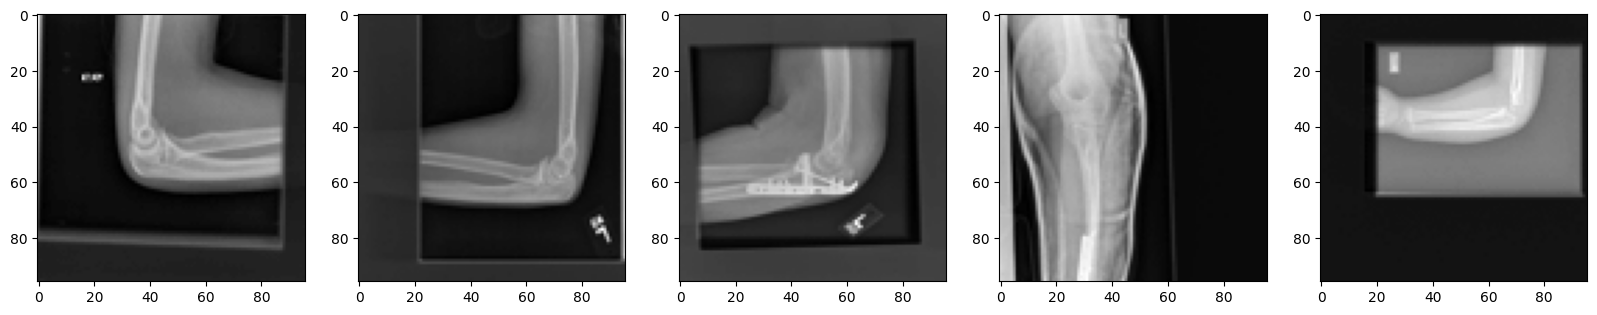

In [8]:
show_data(X_train)

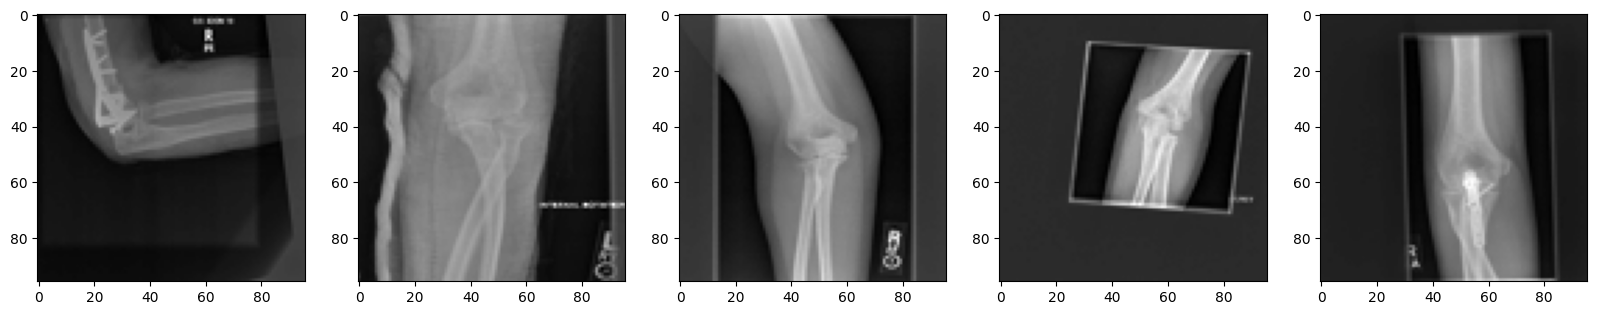

In [9]:
show_data(X_val)

### Finetuning ResNet50 as Encoder

In [10]:
model = ResNet50(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

In [11]:
for layer in model.layers:
    layer.trainable = False

In [12]:
x = Flatten()(model.output)
output = Dense(1, activation='sigmoid')(x)

In [13]:
model = Model(inputs=model.input, outputs=output)

In [14]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 96, 96, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 102, 102,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 48, 48,    │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 48, 48,    │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 48, 48,    │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 50, 50,    │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 24, 24,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 24, 24,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 24, 24,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 24, 24,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 24, 24,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 24, 24,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 24, 24,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 24, 24,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 24, 24,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 24, 24,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 24, 24,    │      1,024 │ conv2_block1_3_c

 Total params: 23,606,145 (90.05 MB)

 Trainable params: 18,433 (72.00 KB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [15]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [16]:
tf.config.run_functions_eagerly(True)
tf.data.experimental.enable_debug_mode()
model.fit(X_train, y_train, epochs=50, batch_size=64, validation_data=(X_val, y_val))

Epoch 1/50
229/229 ━━━━━━━━━━━━━━━━━━━━ 437s 2s/step - accuracy: 0.6598 - loss: 0.9848 - val_accuracy: 0.7054 - val_loss: 0.7751
Epoch 2/50
229/229 ━━━━━━━━━━━━━━━━━━━━ 439s 2s/step - accuracy: 0.7588 - loss: 0.5814 - val_accuracy: 0.6811 - val_loss: 0.9935
Epoch 3/50
229/229 ━━━━━━━━━━━━━━━━━━━━ 438s 2s/step - accuracy: 0.8055 - loss: 0.4601 - val_accuracy: 0.6767 - val_loss: 0.8730
Epoch 4/50
229/229 ━━━━━━━━━━━━━━━━━━━━ 441s 2s/step - accuracy: 0.8305 - loss: 0.3944 - val_accuracy: 0.7091 - val_loss: 0.9111
Epoch 5/50
229/229 ━━━━━━━━━━━━━━━━━━━━ 435s 2s/step - accuracy: 0.8515 - loss: 0.3467 - val_accuracy: 0.6841 - val_loss: 0.8898
Epoch 6/50
229/229 ━━━━━━━━━━━━━━━━━━━━ 442s 2s/step - accuracy: 0.8684 - loss: 0.3141 - val_accuracy: 0.6738 - val_loss: 0.9196
Epoch 7/50
229/229 ━━━━━━━━━━━━━━━━━━━━ 438s 2s/step - accuracy: 0.8804 - loss: 0.2856 - val_accuracy: 0.6907 - val_loss: 1.0175
Epoch 8/50
229/229 ━━━━━━━━━━━━━━━━━━━━ 438s 2s/step - accuracy: 0.8935 - loss: 0.2546 - val_accu

#### saving the encoder model

In [17]:
encoder = Model(model.input, model.get_layer("flatten").output)
encoder.save('encoder.h5')

#### Get the latent vector

In [18]:
x_combined = np.concatenate((X_train, X_val), axis=0)
latent_vectors = encoder.predict(x_combined)

500/500 ━━━━━━━━━━━━━━━━━━━━ 167s 335ms/step


In [19]:
labels = np.concatenate((y_train, y_val), axis=0)
labels = pd.DataFrame(labels)

df_latent = pd.DataFrame(latent_vectors)

df = pd.concat([labels, df_latent], axis=1)
df.to_csv('MURA.csv', index=False)

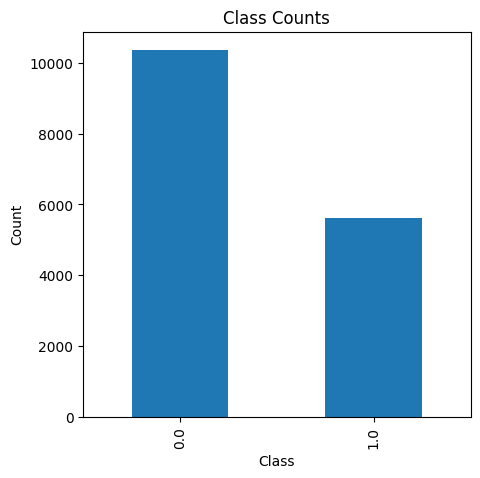

In [20]:
df = pd.read_csv('MURA.csv')
class_counts = df[df.columns[0]].value_counts()

plt.figure(figsize=(5, 5))
class_counts.plot(kind='bar')
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Class Counts')
plt.show()

In [21]:
X = df.drop(columns = df.columns[0])  # Features
y = df[df.columns[0]]  # Labels

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [23]:
X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

In [24]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(12791, 18432)
(12791,)
(3198, 18432)
(3198,)


### Building our Autoencoder based Classifier

In [25]:
input_dim = X_train.shape[1]
encoding_dim = 1024

input_layer = Input(shape=(input_dim,), name='input_layer')
encoded = Dense(4096, activation='relu', name='encoder_dense_1')(input_layer)
encoded = Dense(2048, activation='relu', name='encoder_dense_2')(encoded)
encoded = Dense(1024, activation='relu', name='encoder_dense_3')(encoded)
encoded = Dense(512, activation='relu', name='encoder_dense_4')(encoded)
encoded = Dense(encoding_dim, activation='relu', name='bottleneck_layer')(encoded)

decoded = Dense(512, activation='relu', name='decoder_dense_1')(encoded)
decoded = Dense(1024, activation='relu', name='decoder_dense_2')(decoded)
decoded = Dense(2048, activation='relu', name='decoder_dense_3')(decoded)
decoded = Dense(4096, activation='relu', name='decoder_dense_4')(decoded)
output_layer = Dense(input_dim, activation='sigmoid', name='output_reconstruction')(decoded)

classifier = Dense(512, activation='relu', name='classifier_dense_1')(encoded)
classifier = Dense(256, activation='relu', name='classifier_dense_2')(classifier)
classifier = Dense(128, activation='relu', name='classifier_dense_3')(classifier)
classifier_output = Dense(1, activation='sigmoid', name='output_classification')(classifier)

In [26]:
autoencoder =  Model(input_layer, [output_layer, classifier_output])

In [27]:
autoencoder.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 18432)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_dense_1     │ (None, 4096)      │ 75,501,568 │ input_layer[0][0] │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_dense_2     │ (None, 2048)      │  8,390,656 │ encoder_dense_1[… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_dense_3     │ (None, 1024)      │  2,098,176 │ encoder_dense_2[… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_dense_4     │ (None, 512)       │    524,800 │ encoder_dense_3[… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bottleneck_layer    │ (None, 1024)      │    525,312 │ encoder_dense_4[… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_dense_1     │ (None, 512)       │    524,800 │ bottleneck_layer… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_dense_2     │ (None, 1024)      │    525,312 │ decoder_dense_1[… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ classifier_dense_1  │ (None, 512)       │    524,800 │ bottleneck_layer… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_dense_3     │ (None, 2048)      │  2,099,200 │ decoder_dense_2[… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ classifier_dense_2  │ (None, 256)       │    131,328 │ classifier_dense… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_dense_4     │ (None, 4096)      │  8,392,704 │ decoder_dense_3[… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ classifier_dense_3  │ (None, 128)       │     32,896 │ classifier_dense… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output_reconstruct… │ (None, 18432)     │ 75,515,904 │ decoder_dense_4[… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output_classificat… │ (None, 1)         │        129 │ classifier_dense… │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 174,787,585 (666.76 MB)

 Trainable params: 174,787,585 (666.76 MB)

 Non-trainable params: 0 (0.00 B)

In [28]:
autoencoder.compile(optimizer='adam', 
                               loss={'output_reconstruction': 'mean_squared_error', 'output_classification': 'binary_crossentropy'},
                               metrics={'output_classification': 'accuracy'})

In [29]:
autoencoder.fit(X_train, [X_train, y_train], epochs=50, batch_size=256, validation_data=(X_test, [X_test, y_test]))

Epoch 1/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 88s 2s/step - loss: 0.5354 - output_classification_accuracy: 0.6290 - output_classification_loss: 0.2345 - output_reconstruction_loss: 0.3008 - val_loss: 0.2133 - val_output_classification_accuracy: 0.6413 - val_output_classification_loss: 0.1990 - val_output_reconstruction_loss: 0.0143
Epoch 2/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 83s 2s/step - loss: 0.2000 - output_classification_accuracy: 0.7151 - output_classification_loss: 0.1861 - output_reconstruction_loss: 0.0140 - val_loss: 0.2129 - val_output_classification_accuracy: 0.7186 - val_output_classification_loss: 0.1994 - val_output_reconstruction_loss: 0.0135
Epoch 3/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 83s 2s/step - loss: 0.1691 - output_classification_accuracy: 0.7869 - output_classification_loss: 0.1557 - output_reconstruction_loss: 0.0134 - val_loss: 0.2099 - val_output_classification_accuracy: 0.7183 - val_output_classification_loss: 0.1964 - val_output_reconstruction_loss: 0.0134
Epoch 4/50
50/50 ━━━━━

In [30]:
autoencoder_output, y_pred = autoencoder.predict(X_test)

100/100 ━━━━━━━━━━━━━━━━━━━━ 7s 68ms/step


In [31]:
y_pred = (y_pred > 0.5).astype(int)

In [32]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
accuracy = accuracy_score(y_test, y_pred)*100
precision = precision_score(y_test, y_pred, average='macro')*100
recall = recall_score(y_test, y_pred, average='macro')*100
f1 = f1_score(y_test, y_pred, average='macro')*100

In [33]:
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')

Accuracy: 74.2026
Precision: 72.0842
Recall: 72.6251
F1 Score: 72.3153


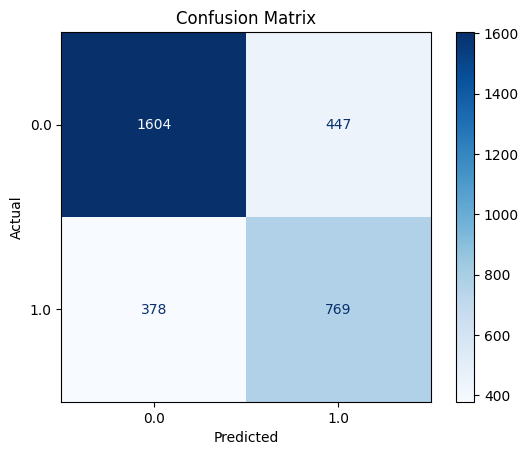

In [34]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)

unique_labels = sorted(set(y_test))

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=unique_labels)
disp.plot(cmap=plt.cm.Blues)

plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.show()

### Implementing SMOTETomek on imbalance data

In [35]:
from imblearn.combine import SMOTETomek
senn = SMOTETomek(random_state=42)
X_resampled, y_resampled = senn.fit_resample(X, y)

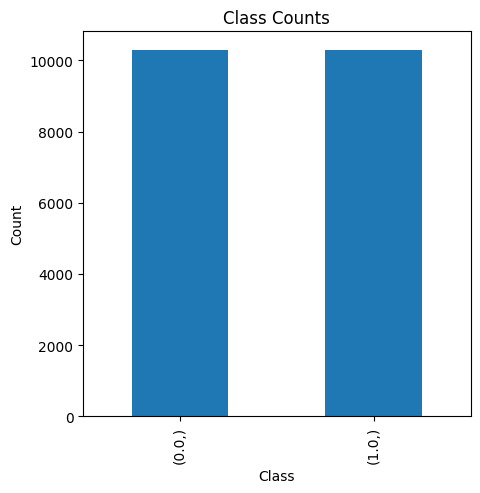

In [36]:
df = pd.DataFrame(y_resampled)
class_counts = df.value_counts()

plt.figure(figsize=(5, 5))
class_counts.plot(kind='bar')
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Class Counts')
plt.show()

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

In [38]:
X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

In [39]:
autoencoder_1 =  Model(input_layer, [output_layer, classifier_output])

autoencoder_1.compile(optimizer='adam', 
                               loss={'output_reconstruction': 'mean_squared_error', 'output_classification': 'binary_crossentropy'},
                               metrics={'output_classification': 'accuracy'})

In [ ]:
autoencoder_1.fit(X_train, [X_train, y_train], epochs=50, batch_size=256, validation_data=(X_test, [X_test, y_test]))

#### saving the classifier model

In [41]:
autoencoder_1.save('classifier.h5')

In [42]:
autoencoder_output, y_pred = autoencoder_1.predict(X_test)

129/129 ━━━━━━━━━━━━━━━━━━━━ 8s 66ms/step


In [43]:
y_pred = (y_pred > 0.5).astype(int)

In [44]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
accuracy = accuracy_score(y_test, y_pred)*100
precision = precision_score(y_test, y_pred, average='macro')*100
recall = recall_score(y_test, y_pred, average='macro')*100
f1 = f1_score(y_test, y_pred, average='macro')*100

In [45]:
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')

Accuracy: 93.7849
Precision: 93.8061
Recall: 93.7621
F1 Score: 93.7784


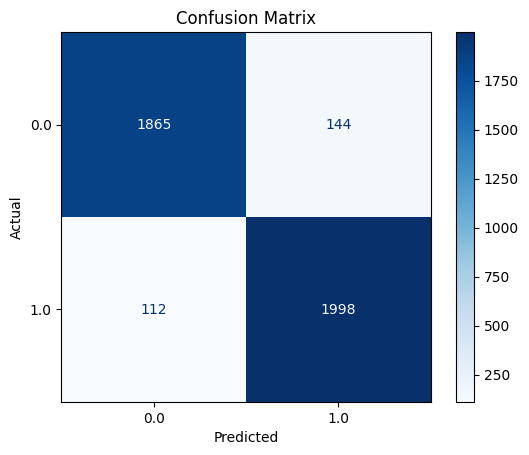

In [46]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)

unique_labels = sorted(set(y_test))

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=unique_labels)
disp.plot(cmap=plt.cm.Blues)

plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()